# Libraries

In [82]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob
from tqdm import tqdm
from torchvision import transforms
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time
import sys
from operator import add
%matplotlib inline

In [83]:
import torch.nn as nn
import torch.nn.functional as F

In [84]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

## Constants

In [85]:
train_images = 20
epochs = 20
batch_size = 8
lr = 1e-4

subset_mode = True

## Paths

In [86]:
images_PATH = '../input/chest-xray-masks-and-labels/Lung Segmentation/'
# image_path_test = '../input/chest-xray-masks-and-labels/Lung Segmentation/test/' 
checkpoint_PATH = 'unet_centralized'
checkpoint_PATH = checkpoint_PATH + "_" + str(train_images) + "_images_" + str(epochs) + "_epochs" + ".pth"
print(checkpoint_PATH)
results_PATH = './'

unet_centralized_20_images_20_epochs.pth


## Transforms

In [87]:
mean0_1, std0_1 = [0.0, 0.0, 0.0], [1.0, 1.0, 1.0]
mean_imgnet, std_imgnet = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean1_1gray, std1_1gray = [0.5, ], [0.5, ]
dim = 256

image_tfms = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean1_1gray, 
                         std = std1_1gray)
])

mask_tfms = transforms.Compose([
    transforms.Resize((dim, dim)),
    transforms.ToTensor()
])

# Load Data, Trainloader

In [88]:
images = os.listdir(images_PATH+'CXR_png/')
mask = os.listdir(images_PATH+'masks/')
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

check = [i for i in mask if "mask" in i]

In [89]:
print(images[0:5])
print()
print(mask[0:5])
print()

['CHNCXR_0092_0.png', 'CHNCXR_0322_0.png', 'CHNCXR_0304_0.png', 'CHNCXR_0572_1.png', 'CHNCXR_0547_1.png']

['CHNCXR_0300_0_mask', 'CHNCXR_0083_0_mask', 'CHNCXR_0094_0_mask', 'CHNCXR_0597_1_mask', 'MCUCXR_0017_0']



In [90]:
testing_files = set(os.listdir(images_PATH+'CXR_png/')) & set(os.listdir(images_PATH+'masks/'))
training_files = check

## Dataset Class

In [91]:
class SegmentationDS(Dataset):
    """ create dataset by using image path and their labels """
    def __init__ (self, path, files, flag = "MONT", transform = (None, None)):
        self.path = images_PATH
        self.files = files
        self.flag = flag
        self.transform = transform

        
    def __len__(self):
        return len (self.files)

    def __getitem__(self, index):
        
        f = sorted(list(self.files))
        if self.flag == "MONT":    
            image = Image.open(os.path.join(self.path, "CXR_png", f[index])).convert('L')
            mask = Image.open(os.path.join(self.path, "masks", f[index])).convert('L')

        elif self.flag == "SHEN":
            image = Image.open(os.path.join(self.path, "CXR_png", f[index].split("_mask")[0] + ".png")).convert('L')
            mask = Image.open(os.path.join(self.path, "masks", f[index] + ".png")).convert('L')


        if self.transform != (None, None):
            image = self.transform[0](image)
            mask = self.transform[1](mask)
            
        return image, mask

In [92]:
Mont_ds = SegmentationDS(images_PATH, testing_files, flag = "MONT", transform = (image_tfms, mask_tfms))
Shen_ds = SegmentationDS(images_PATH, training_files, flag = "SHEN", transform = (image_tfms, mask_tfms))


In [93]:
# subset_ds = torch.utils.data.Subset(Mont_ds, indices = [i for i in range(train_images)])
# print(type(subset_ds)) # Subset of Dataset class, so should work fine with Trainloader!!

In [94]:
# idx = np.random.choice (len (subset_ds))
# img, lbl = subset_ds [idx]
# print (img.shape)
# print (lbl.shape)
# print(img.min(), img.max())
# print(lbl.min(), lbl.max())
# imshow(img, mean1_1gray, std1_1gray)
# imshow(lbl, mean1_1gray, std1_1gray)

In [95]:
print(type(Mont_ds))
len(Mont_ds), len(Shen_ds)

<class '__main__.SegmentationDS'>


(138, 566)

In [96]:
def imshow (img, mean_set, std_set):
    """ visualize torch tensor image """
    
    if img.shape[0] == 3:
        img = img.numpy ().transpose (1, 2, 0)
        mean = mean_set
        std = std_set
        img = img * std + mean
        img = np.clip (img, 0, 1)
        plt.figure (figsize = (5, 5))
        plt.imshow (img)
        
    elif img.shape[0] == 1:
        img = img.numpy ().transpose (1, 2, 0)
        mean = mean_set
        std = std_set
        img = img * std + mean
        img = np.clip (img, 0, 1)
    
        plt.figure (figsize = (5, 5))
        plt.imshow (img,cmap='gray')

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)


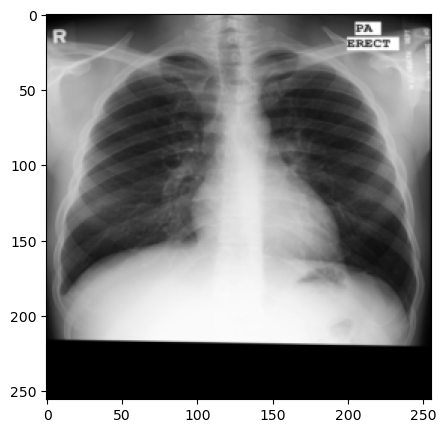

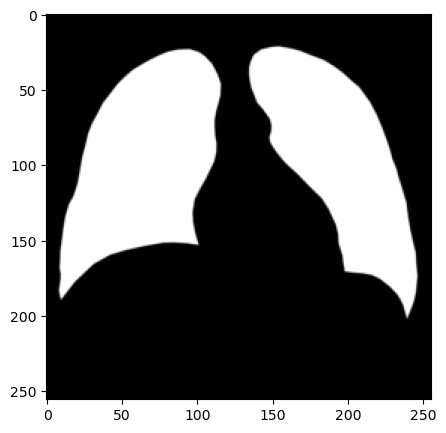

In [97]:
idx = np.random.choice (len (Mont_ds))
img, lbl = Mont_ds [idx]
print (img.shape)
print (lbl.shape)
print(img.min(), img.max())
print(lbl.min(), lbl.max())
imshow(img, mean1_1gray, std1_1gray)
imshow(lbl, mean1_1gray, std1_1gray)

## Subset DS, Trainloader (For debugging)

In [98]:
train_ds = torch.utils.data.ConcatDataset([Mont_ds, Shen_ds])

if subset_mode == True:
    train_ds = torch.utils.data.Subset(train_ds, indices = [i for i in range(train_images)])

len(train_ds)

20

In [99]:
train_size = int(0.80 * len(train_ds))
valid_size = len(train_ds) - train_size
train_ds, valid_ds = torch.utils.data.random_split(train_ds, [train_size, valid_size])

print(len(train_ds), len(valid_ds))

16 4


## Trainloaders

In [100]:
train_dl = DataLoader (train_ds, batch_size = 8, shuffle = True)
valid_dl = DataLoader (valid_ds, batch_size = 8, shuffle = True)

# MCOZ PLBS

## Loss Function

In [101]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

## Metrics

In [102]:
def calculate_metrics(y_pred, y_true):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
#     score_f1 = f1_score(y_true, y_pred)
#     score_recall = recall_score(y_true, y_pred)
#     score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_acc]

In [103]:
try:
    from torchsummary import summary
except ImportError:
    !pip3 -q install torchsummary
    from torchsummary import summary

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## U-Net Model

In [105]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class Unet_Builder(nn.Module):
    def __init__(self, input_channel:int = 3, output_channel:int = 1):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(input_channel, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, output_channel, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

    
    
model = Unet_Builder(input_channel=1, output_channel=1)
# model.eval()

In [106]:
summary(model, input_size=(1, dim, dim), device = 'cpu')     ## dim = 256

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        conv_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
     encoder_block-9  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14    

In [107]:
def save_checkpoint (state, filename):
    """ saving model's weights """
    print ('=> saving checkpoint')
    torch.save (state, filename)

In [108]:
model = model.to(device) # M
loss_fn = DiceBCELoss() # C
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # O

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
# metric_fn = calculate_metrics()
best_valid_loss = float("inf")

## Training Loop

In [109]:
def train(model, loader, optimizer, loss_fn, metric_fn, device): # This does it for only one epoch
    epoch_loss = 0.0
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    steps = len(loader)
    model.train()
    for i, (x, y) in enumerate (loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad() # Z
        y_pred = model(x) # P
        loss = loss_fn(y_pred, y) # L 
        loss.backward() # B
        
        score = metric_fn(y_pred, y)
        metrics_score = list(map(add, metrics_score, score))
        
        optimizer.step() # S
        epoch_loss += loss.item()
        
        sys.stdout.flush()
        sys.stdout.write('\r Step: [%2d/%2d], loss: %.4f - acc: %.4f' % (i, steps, loss.item(), score[1]))
    sys.stdout.write('\r')

    epoch_loss = epoch_loss/len(loader)
    
    epoch_jaccard = metrics_score[0]/len(loader)
#     epoch_f1 = metrics_score[1]/len(loader)
    epoch_acc = metrics_score[1]/len(loader)
    
    return epoch_loss, epoch_jaccard, epoch_acc

## Evaluation

In [110]:
def evaluate(model, loader, loss_fn, metric_fn, device):
    epoch_loss = 0.0
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            
            score = metric_fn(y_pred, y)
            metrics_score = list(map(add, metrics_score, score))
            
            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(loader)
        
        epoch_jaccard = metrics_score[0] / len(loader)
#         epoch_f1 = metrics_score[1] / len(loader)
        epoch_acc = metrics_score[1] / len(loader)
    
    return epoch_loss, epoch_jaccard, epoch_acc

In [111]:
torch.cuda.empty_cache()

In [112]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Run (Training Loop, Eval + Save Model)

In [113]:
def fit (model, train_dl, valid_dl, optimizer, epochs, loss_fn, metric_fn, checkpoint_PATH):
    """ fiting model to dataloaders, saving best weights and showing results """
    losses, val_losses, accs, val_accs = [], [], [], []
    jaccards, val_jaccards = [], []
    best_val_loss = float("inf")
    
    since = time.time()
    for epoch in range (epochs):
        ts = time.time()
        
        loss, jaccard, acc = train(model, train_dl, optimizer, loss_fn, metric_fn, device) # This is just Training with Extra Steps!! (Logging loss etc.)
        val_loss, val_jaccard, val_acc = evaluate(model, valid_dl, loss_fn, metric_fn, device)

        
        losses.append(loss)
        accs.append(acc)
        jaccards.append(jaccard)
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_jaccards.append(val_jaccard)
        
        te = time.time()
        
        if val_loss < best_val_loss:
            data_str = f"===> Valid loss improved from {best_val_loss:2.4f} to {val_loss:2.4f}. Saving checkpoint: {checkpoint_PATH}"
            print(data_str)
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_PATH)

        epoch_mins, epoch_secs = epoch_time(ts, te)
        
        print ('Epoch [{}/{}], loss: {:.4f} - jaccard: {:.4f} - acc: {:.4f} - val_loss: {:.4f} - val_jaccard: {:.4f} - val_acc: {:.4f}'.format (epoch + 1, epochs, loss, jaccard, acc, val_loss, val_jaccard, val_acc))
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        
    period = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(period // 60, period % 60))

    return dict(loss = losses, val_loss = val_losses, acc = accs, val_acc = val_accs, jaccard = jaccards, val_jaccard = val_jaccards)

In [114]:
res = fit(model, train_dl, valid_dl, optimizer, epochs, loss_fn, calculate_metrics, checkpoint_PATH)

===> Valid loss improved from inf to 1.3508. Saving checkpoint: unet_centralized_20_images_20_epochs.pth
Epoch [1/20], loss: 1.3059 - jaccard: 0.0001 - acc: 0.7401 - val_loss: 1.3508 - val_jaccard: 0.0000 - val_acc: 0.7708
Time: 0m 9s
===> Valid loss improved from 1.3508 to 1.3436. Saving checkpoint: unet_centralized_20_images_20_epochs.pth
Epoch [2/20], loss: 1.1667 - jaccard: 0.0016 - acc: 0.7431 - val_loss: 1.3436 - val_jaccard: 0.0000 - val_acc: 0.7708
Time: 0m 8s
===> Valid loss improved from 1.3436 to 1.3363. Saving checkpoint: unet_centralized_20_images_20_epochs.pth
Epoch [3/20], loss: 1.0431 - jaccard: 0.2167 - acc: 0.7926 - val_loss: 1.3363 - val_jaccard: 0.0000 - val_acc: 0.7708
Time: 0m 8s
===> Valid loss improved from 1.3363 to 1.3278. Saving checkpoint: unet_centralized_20_images_20_epochs.pth
Epoch [4/20], loss: 1.0159 - jaccard: 0.4818 - acc: 0.8438 - val_loss: 1.3278 - val_jaccard: 0.0000 - val_acc: 0.7708
Time: 0m 8s
===> Valid loss improved from 1.3278 to 1.3171. Sav

## Log

In [115]:
def plot_acc_loss (loss, val_loss, acc, val_acc):
    """ plot training and validation loss and accuracy """
    plt.figure (figsize = (12, 4))
    plt.subplot (1, 2, 1)
    plt.plot (range (len (loss)), loss, 'b-', label = 'Training')
    plt.plot (range (len (loss)), val_loss, 'bo-', label = 'Validation')
    plt.xlabel ('Epochs')
    plt.ylabel ('Loss')
    plt.title ('Loss')
    plt.legend ()

    plt.subplot (1, 2, 2)
    plt.plot (range (len (acc)), acc, 'b-', label = 'Training')
    plt.plot (range (len (acc)), val_acc, 'bo-', label = 'Validation')
    plt.xlabel ('Epochs')
    plt.ylabel ('accuracy')
    plt.title ('Accuracy')
    plt.legend ()

    plt.show ()

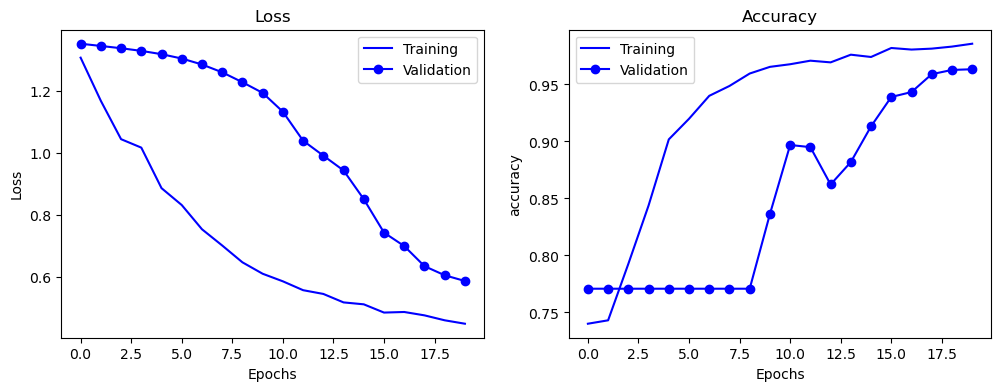

In [116]:
loss, val_loss = res['loss'], res['val_loss']
acc, val_acc = res['acc'], res['val_acc']
plot_acc_loss (loss, val_loss, acc, val_acc)

# Verify the Model

In [117]:
with torch.no_grad():
    for x, y in valid_dl:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        y_pred = model(x)
        break

In [118]:
pred = y_pred.cpu().numpy()
ynum = y.cpu().numpy()

pred.shape, ynum.shape

((4, 1, 256, 256), (4, 1, 256, 256))

In [119]:
pred = pred.reshape(len(pred), dim, dim)
ynum = ynum.reshape(len(ynum), dim, dim)

pred = pred > 0.5
pred = np.array(pred, dtype=np.uint8)

ynum = ynum > 0.5
ynum = np.array(ynum, dtype=np.uint8)

pred.shape, ynum.shape

((4, 256, 256), (4, 256, 256))

PREDICTED


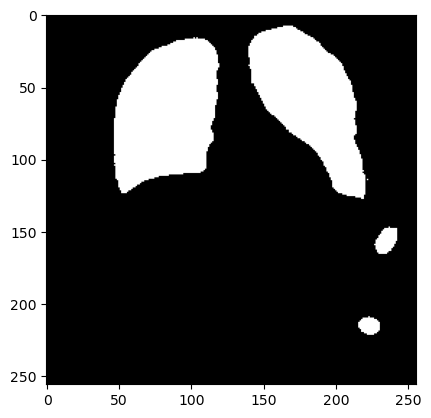

In [122]:
print("PREDICTED")
plt.imshow(pred[3], cmap='gray')

ACTUAL


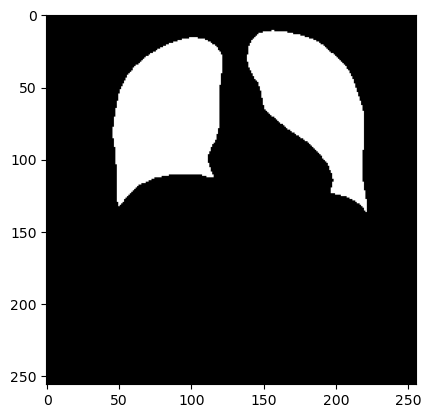

In [123]:
print("ACTUAL")
plt.imshow(ynum[3], cmap='gray')